In [33]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

In [34]:
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))
exn = 1.5e-6
eyn = 1.5e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)
p = 24 # beam momentum (GeV/c)
momentum = 24 # beam momentum (GeV/c)
Brho = 24*3.3356
PS_radius = 70.079

In [42]:
mad = Madx(stdout=False)

PS_REPO = "../../../../models/acc-models-ps/"

mad.call(PS_REPO+"ps_mu.seq")
mad.call(PS_REPO+"ps_ss.seq")
mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')
twiss_initial = mad.twiss().dframe() 

In [43]:
def tune_match(Qx,Qxp,Qy,Qyp,momentum,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    madx.call(PS_REPO+"ps_mu.seq")
    madx.call(PS_REPO+"ps_ss.seq")
    madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

    madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence = "PS")

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
      ptc_create_universe;
      ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
      IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
      }
      ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
      }
      ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict

In [47]:
pfw_dict_6_33, tune_info_dict_6_33 = tune_match(Qx=0.33,Qxp=-1.239,Qy=0.3,Qyp=-0.242, momentum=24, ex=ex, ey=ey) # Chroma from measurements on 12.11.21 

H-tune: 6.33, H-Chroma: -1.241
V-Tune: 6.3, V-Chroma: -0.242

PFW settings: 
  k1prpfwf: 0.000226
  k1prpfwd: -0.000393
  k2prpfwf: 0.005239
  k2prpfwd: -0.01635


In [56]:
mad.input("k1prpfwf = "+str(pfw_dict_6_33["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_6_33["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_6_33["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_6_33["k2prpfwd"])+";")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')
twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')

mad.use(sequence = "PS")
twiss_cycled = mad.twiss().dframe()


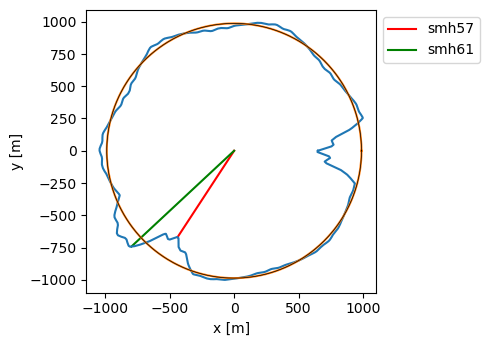

In [91]:
from matplotlib import patches
c = twiss_initial.s[-1]
r = c/2*np.pi

fig, ax = plt.subplots(tight_layout=True, figsize=(5, 5))

x_x = []
x_y = []
for i in range(len(twiss_initial)):
    x = (r+10000*twiss_initial.x[i])*np.cos(twiss_initial.s[i]*2*np.pi/c)
    y = (r+10000*twiss_initial.x[i])*np.sin(-twiss_initial.s[i]*2*np.pi/c) # Clockwise
    x_x.append(x)
    x_y.append(y)

y_x = []
y_y = []
for i in range(len(twiss_initial)):
    x = (r+10000*twiss_initial.y[i])*np.cos(twiss_initial.s[i]*2*np.pi/c)
    y = (r+10000*twiss_initial.y[i])*np.sin(-twiss_initial.s[i]*2*np.pi/c) # Clockwise
    y_x.append(x)
    y_y.append(y)

theta = twiss_initial.s*2*np.pi/c
x = r*np.cos(theta)
y = r*np.sin(theta)

loc_57 = twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['s']
x_57 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['x'])*np.cos(loc_57*2*np.pi/c)
y_57 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['x'])*np.sin(-loc_57*2*np.pi/c) # Clockwise
# mark 57
ax.plot([0, x_57], [0, y_57], color='red', label='smh57')


loc_61 = twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['s']
x_61 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['x'])*np.cos(loc_61*2*np.pi/c)
y_61 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['x'])*np.sin(-loc_61*2*np.pi/c) # Clockwise
# mark 61
ax.plot([0, x_61], [0, y_61], color='green', label='smh61')


ax.plot(x_x,x_y)
ax.plot(y_x,y_y)
ax.plot(x, y, color="k", lw=0.5)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect("equal")
ax.legend()
# legend top right
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

###
---

In [ ]:


with open("ps_at_q_6_325.json", 'r') as fid:
#with open("bare_line.json", 'r') as fid:
    loaded_dict = json.load(fid)
line = xt.Line.from_dict(loaded_dict)
# line.particle_ref = xp.Particles(
#     p0c = 1.399856671256738,
#     q = 54./208.,
#     m0 = 0.931494*(207.947/208.),
# )

In [ ]:
from signal_gen import generate_chirp_signal

EXCITER_SAMPLING_FREQ = 1e6
FREV = 470151.0308

CHIRP_START = FREV * .3
CHIRP_STOP = FREV * .35

exciter_time, exciter_signal, turns = generate_chirp_signal(
    sampling_freq = EXCITER_SAMPLING_FREQ,
    chirp_start_freq = CHIRP_START,
    chirp_stop_freq = CHIRP_STOP
)

In [ ]:
ctx = xo.ContextCpu()

N_PART = int( 5e2 )
N_TURN = int( 5e2 )

exciter = xt.Exciter(
    _context = ctx,
    samples = exciter_signal,
    sampling = EXCITER_SAMPLING_FREQ,
    frev = FREV,
    start_turn = 0,
    knl = [0.001]
)

smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)

smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)

In [ ]:
# line.insert_element(
#     element = exciter,
#     name = 'EXCITER',
#     index = 'pr.kfb97'
# )
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)

In [ ]:
from pybt.tools.particles import beam_distrib_norm as bdn
from pybt.tools.particles import dpp_distrib_norm as ddn

EMIT = 5e-6
parts_x = bdn(
    alpha = 0.4244839305372821,
    beta = 26.875635235760765,
    eps = EMIT,
    nparts = N_PART,
    nsigma = [5, 5.0000001]
)
parts_y = bdn(
    alpha = -0.07355720828438532,
    beta = 9.64757288019518,
    eps = EMIT,
    nparts = N_PART,
    nsigma = [5, 5.0000001]
)
parts_s = ddn(
    dpp = 1e-3*0,
    nparts = N_PART,
    nsigma = 2
)

parts_x_disp =  np.array(parts_x[:,0]) + np.array(4.043911519775766 * parts_s)
parts_px_disp = np.array(parts_x[:,1]) + np.array(-0.03630510415370579 * parts_s)

parts_y_disp =  np.array(parts_y[:,0]) + np.array(7.824523014183614e-13 * parts_s)
parts_py_disp = np.array(parts_y[:,1]) + np.array(-5.067241948016229e-14 * parts_s)

In [ ]:
tracker = line.build_tracker()
parts = tracker.build_particles(
    x =  parts_x_disp,
    px = parts_px_disp,
    y =  parts_y_disp,
    py = parts_py_disp
)

In [ ]:
tracker.track(
    particles = parts, 
    num_turns = N_TURN
)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(parts_x_disp, parts_px_disp)

In [ ]:
# for i in range(N_TURN):
#     fig, ax = plt.subplots()
#     ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i])
#     fig.suptitle(f"{i:<4}")

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.005, 0.005)
    fig.suptitle(f"{i:>4}")
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save("close_to_third.gif", writer=PillowWriter(fps=30))


In [ ]:
tw = tracker.twiss(method='4d')
tw['qx']